In [2]:
!pip install tensorflow  opencv-python matplotlib

In [68]:
import tensorflow as tf
import os

In [69]:

import cv2
import imghdr

In [70]:
import numpy as np
from matplotlib import pyplot as plt

In [71]:
data = tf.keras.utils.image_dataset_from_directory('data/seg_train/seg_train')

Found 12983 files belonging to 6 classes.


In [72]:
def extract_labels(image, label):
    return label

In [73]:
labels = data.map(extract_labels)

In [74]:
labels = list(labels)

In [75]:
data_iterator = data.as_numpy_iterator()

In [76]:
batch = data_iterator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
labels_dataset = {'mountains': 3, 'glaciers':2

In [78]:
data = data.map(lambda x,y: (x/255, y))

In [81]:
data.as_numpy_iterator().next()[0].max()

1.0

In [82]:
284+81+40

405

In [83]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
print(train_size,val_size,test_size)

284 82 40


In [100]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [85]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [87]:
model = Sequential()

In [88]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [141]:
batches_per_epoch = len(train)
lr_decay = (1.0/0.75 - 1)/batches_per_epoch
lr_decay
opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001 ,decay = lr_decay)

In [142]:
model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [91]:
logdir='logs'

In [95]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [143]:

hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback,early_stopping])

Epoch 1/5
284/284 [==============================] - 340s 1s/step - loss: 0.0281 - accuracy: 0.9931 - val_loss: 1.2193 - val_accuracy: 0.7942
Epoch 2/5
284/284 [==============================] - 368s 1s/step - loss: 0.0205 - accuracy: 0.9957 - val_loss: 1.2176 - val_accuracy: 0.7931
Epoch 3/5
284/284 [==============================] - 368s 1s/step - loss: 0.0154 - accuracy: 0.9966 - val_loss: 1.2509 - val_accuracy: 0.7904
Epoch 4/5
284/284 [==============================] - 371s 1s/step - loss: 0.0135 - accuracy: 0.9968 - val_loss: 1.2647 - val_accuracy: 0.7923


In [144]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [145]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
X,y = batch
y= np.eye(6)[y]


In [146]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    y= np.eye(6)[y]
    yhat = model.predict(X)
    
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 0s 461ms/step


In [147]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.76648134, shape=(), dtype=float32) tf.Tensor(0.7592447, shape=(), dtype=float32) tf.Tensor(0.9213218, shape=(), dtype=float32)


In [148]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--',label = 'acc')
    plt.plot(history.history['val_accuracy'],'ro--',label = 'val_acc')
    plt.title('train_acc vs val_acc')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()
    
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--',label = 'loss')
    plt.plot(history.history['val_loss'],'ro--',label = 'val_loss')
    plt.title('train_loss vs val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    
    plt.show()

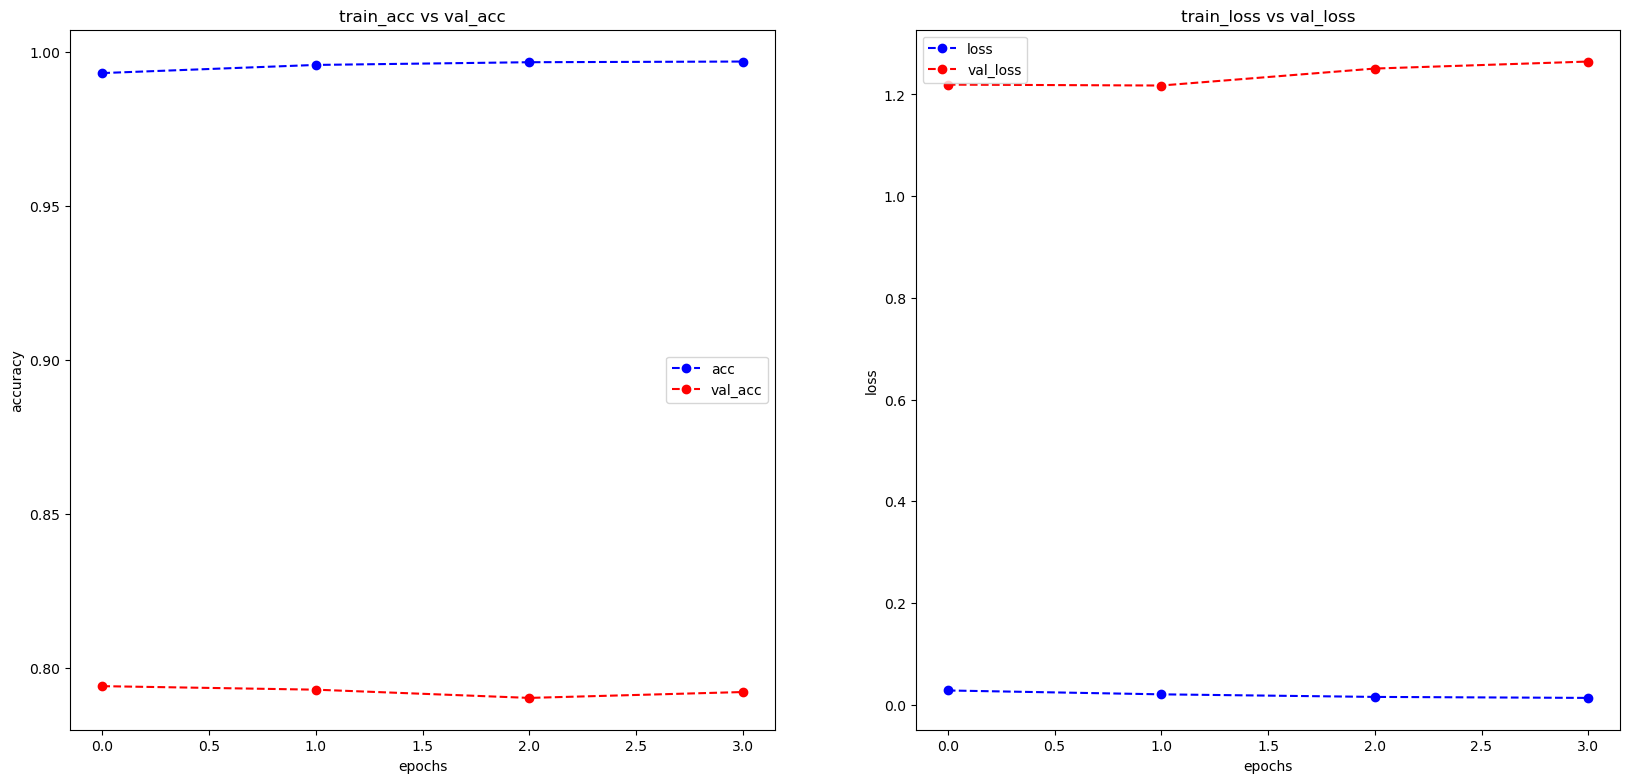

In [149]:
plot_accuracy_loss(hist)